环境设计与改进

In [105]:
# fit5226_grid_qtable.py
# -------------------------------------------------------------
# 适用于 FIT5226 多智能体运输任务的 5×5 网格环境 + Q-Table 学习示例
# Author: ChatGPT (2025-05-02)
# -------------------------------------------------------------
import numpy as np
import random
from collections import defaultdict

# ------------------ 环境常量 ------------------
GRID_SIZE = 5
NUM_AGENTS = 4
#            北      南      东      西
ACTIONS = [(0, -1), (0, 1), (1, 0), (-1, 0)]
PICKUP_REWARD    = +40      # 在 A 点拾货
DELIVERY_REWARD  = +60     # 在 B 点交货
STEP_PENALTY     = -1    # 时间步惩罚
COLLISION_PENALTY = -50     # 对向撞车惩罚
# 8 邻域坐标（不含自身）
NEIGHBORS = [(dx, dy) for dx in (-1,0,1)
                         for dy in (-1,0,1)
                         if (dx,dy)!=(0,0)]

# =============================================================
# 1. 多智能体网格环境
# =============================================================
class MultiAgentGridEnv:
    """5×5 运输任务环境，支持 4 智能体 + 中央时钟 + 对向传感器"""
    def __init__(self, grid_size=GRID_SIZE, num_agents=NUM_AGENTS, seed=None):
        self.grid_size   = grid_size
        self.num_agents  = num_agents
        self.rng         = np.random.default_rng(seed)
        self.clock_idx   = 0           # 中央时钟索引
        self.reset()

    # ------------------ 私有工具函数 ------------------
    def _opposite_agent_at(self, cell, me):
        """判断 cell 格是否存在“朝相反方向驶来”的其他智能体"""
        for j, pos in enumerate(self.positions):
            if j == me or pos != cell:
                continue
            # 自己 heading==0（停在 A/B）依旧将对向视为危险
            if self.heading[j] == -1 * self.heading[me] or self.heading[me] == 0:
                return True
        return False

    def _observe(self, i):
        """返回智能体 i 的离散观测（tuple，可直接做 Q-table 键）"""
        x, y       = self.positions[i]
        obs_basic  = (x, y, self.carry[i], *self.A, *self.B)
        # 8 邻域危险标志（1 = 有对向来车）
        danger_flgs = tuple(
            1 if (0 <= x+dx < GRID_SIZE and
                  0 <= y+dy < GRID_SIZE and
                  self._opposite_agent_at((x+dx, y+dy), i))
            else 0
            for dx, dy in NEIGHBORS
        )
        return obs_basic + danger_flgs

    def _update_heading(self):
        """根据携物状态/所处端点更新逻辑行驶方向"""
        self.heading = []
        for carry, pos in zip(self.carry, self.positions):
            if carry and pos != self.B:
                self.heading.append(+1)    # A → B
            elif (not carry) and pos != self.A:
                self.heading.append(-1)    # B → A
            else:
                self.heading.append(0)     # 停留端点

    def _detect_collisions(self, rewards):
        """检测对向碰撞；返回本步新增碰撞次数"""
        initial = self.total_collisions
        # 统计每格有哪些 agent
        cell_to_agents = {}
        for idx, pos in enumerate(self.positions):
            cell_to_agents.setdefault(pos, []).append(idx)

        for pos, agents in cell_to_agents.items():
            if len(agents) < 2 or pos in (self.A, self.B):
                continue
            hs = {self.heading[a] for a in agents}
            if +1 in hs and -1 in hs:           # 对向相遇
                self.total_collisions += 1
                for a in agents:
                    rewards[a] += COLLISION_PENALTY
        return self.total_collisions - initial

    # ------------------ 公共 API ------------------
    def reset(self):
        """随机放置 A/B 与智能体位置，返回初始观测 dict"""
        self.A = tuple(self.rng.integers(0, GRID_SIZE, 2))
        while True:
            self.B = tuple(self.rng.integers(0, GRID_SIZE, 2))
            if self.B != self.A:
                break
        # 偶数号起点 A，奇数号起点 B
        self.positions = [self.A if i%2==0 else self.B for i in range(NUM_AGENTS)]
        self.carry     = [int(p == self.A) for p in self.positions]
        self.directions= [(0,0)]*NUM_AGENTS
        self.heading   = [0]*NUM_AGENTS
        self.total_collisions = 0
        self.clock_idx = 0
        return {i: self._observe(i) for i in range(NUM_AGENTS)}

    def step(self, actions):
        """
        actions: dict {agent_id: action_idx}
        returns: obs, rewards, done, info
        """
        # 1) 决定本轮执行顺序（central clock）
        order = [(self.clock_idx+i) % NUM_AGENTS for i in range(NUM_AGENTS)]
        self.clock_idx = (self.clock_idx + 1) % NUM_AGENTS

        # 初始化奖励
        rewards = [STEP_PENALTY]*NUM_AGENTS

        # 2) 逐个执行动作
        for aid in order:
            a_idx = actions.get(aid, 0)                 # 缺省动作为向北(0,–1)
            if not 0 <= a_idx < len(ACTIONS):           # 越界保护
                a_idx = 0
            dx, dy = ACTIONS[a_idx]
            self.directions[aid] = (dx, dy)

            ox, oy = self.positions[aid]
            nx = int(np.clip(ox+dx, 0, GRID_SIZE-1))
            ny = int(np.clip(oy+dy, 0, GRID_SIZE-1))
            self.positions[aid] = (nx, ny)

            # 交互：A 点取货 / B 点交货
            if (nx, ny) == self.A and not self.carry[aid]:
                self.carry[aid] = True
                rewards[aid]  += PICKUP_REWARD
            elif (nx, ny) == self.B and self.carry[aid]:
                self.carry[aid] = False
                rewards[aid]  += DELIVERY_REWARD

        # 3) 更新 heading & 碰撞检测
        self._update_heading()
        new_col = self._detect_collisions(rewards)

        obs_dict = {i:self._observe(i) for i in range(NUM_AGENTS)}
        rwd_dict = {i: rewards[i]       for i in range(NUM_AGENTS)}
        info = {"step_collisions": new_col,
                "total_collisions": self.total_collisions,
                "order": order}
        return obs_dict, rwd_dict, False, info

    # ---------- 可选渲染 ----------
    def render(self):
        """简单文本渲染"""
        grid = [[" . " for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]
        ax, ay = self.A; bx, by = self.B
        grid[ay][ax] = " A "
        grid[by][bx] = " B "
        for i,(x,y) in enumerate(self.positions):
            mark = f"{i}{'*' if self.carry[i] else ''}"
            grid[y][x] = mark.rjust(3)
        print("\n".join("".join(row) for row in grid), "\n")


上述 step 函数实现了中央时钟顺序和基本的动作效果：
中央时钟 (Central-Clock)：使用 clock_idx 决定当前步哪个智能体先移动。order 列表根据时钟指针轮转确定智能体执行顺序。这样保证在多步过程中，各智能体轮流获得先手机会，而不是每步随机顺序​
file-6dmvtkkb3cgmfmtta2m5tj
。例如，若 clock_idx=0，本步顺序为 0,1,2,3 号智能体；下一步 clock_idx 增1，则顺序为 1,2,3,0，如此循环。这避免了固定同一个Agent每次最后行动的不公平情况。
移动与交互：按顺序更新每个Agent的位置，并处理在 A 点的自动拾取和在 B 点的自动交付。每步每个Agent先赋一个小的时间惩罚 STEP_PENALTY（-0.1），如果该步Agent成功拾取或交付物品，会在其奖励中额外加入 PICKUP_REWARD（+1）或 DELIVERY_REWARD（+10）。
更新朝向：_update_heading() 根据智能体当前是否携物以及位置，设置其逻辑朝向标记：携物且未到B视为正向 (1，即A→B方向)，空手且未到A视为反向 (-1，即B→A方向)，否则为0。这个标记用于碰撞检测和传感器判断。

最后是碰撞检测逻辑：z z

碰撞检测：在 _detect_collisions 中，我们将位于同一格子的多个智能体分组。如果同一格有两个或以上智能体，且它们的朝向集合同时包含 1 和 -1，则表示有Agent正面相对而行发生对头碰撞​
file-6dmvtkkb3cgmfmtta2m5tj
。在这种情况下，并且该格子不是终点 A 或 B（题目规定在A、B上的碰撞不计），我们认定一次碰撞发生，对碰撞涉及的每个Agent都扣除 COLLISION_PENALTY（-5）。例如，若两个智能体分别从A->B和B->A方向走进同一个格子，即对头碰撞，每人-5奖励。本步可能有多个格子发生碰撞，函数会返回该步新增加的碰撞次数。

累计碰撞计数：self.collisions 记录总碰撞次数，可用于监控训练中碰撞频率下降情况。info字典中返回了本步碰撞数，以供训练统计。

通过以上环境改进，每个智能体现在只能感知潜在的对头碰撞危险，并通过中央时序避免并发动作的不确定性，从而为学习协调避碰提供了明确的状态和规则。
注: 由于中央时钟机制，各智能体按固定顺序行动，使环境的转移函数更加确定，有助于加速收敛。同时，邻居传感器仅在存在对向冲突风险时发出信号，从感知层面简化了任务结构，这正是我们“购买”的可选传感器功能之一。

DQN 智能体实现

In [106]:
"""
fit5226_dqn_corrected.py  — DQN 智能体 + 5×5 多智能体运输环境（修正版）
---------------------------------------------------------------------
* 修正点
  1. **Episode 重置**  : 每回合 `env.reset()`，随机化 A/B 与初始站位。
  2. **最长期限**    : 每 episode 最长 30 步 (`MAX_STEP_PER_EP`)；有任一智能体完成一次交付即提前结束。
  3. **统计逻辑**    : 按 episode 归零，按 1 k step 打印区段指标。
  4. **代码结构**    : 其余 DQN、经验回放、目标网络完全保留。

运行：
    python fit5226_dqn_corrected.py   # 默认 50 k 交互步

依赖：PyTorch >=2.0、NumPy
"""

import numpy as np
import random, time, os
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

# 使用上面定义的 MultiAgentGridEnv 类
# from fit5226_env import MultiAgentGridEnv

# ---------- 超参数 ----------
STATE_DIM = 15    # 观测向量维度（x,y,carry,A,B,8 flags）
ACTION_DIM    = 4     # 北南东西
MEM_CAPACITY  = 50_000
BATCH_SIZE    = 200
GAMMA         = 0.95
LR            = 1e-3
EPS_START     = 1.0
EPS_END       = 0.05
EPS_DECAY     = 0.9998
TARGET_SYNC   = 1000   # 每 1 k 学习步软同步
TRAIN_STEPS   = 200000    # 总交互步数
MAX_STEP_PER_EP = 40      # 每 episode 最多步数
SEED          = 42

# ---------- DQN 智能体 ----------
class DQNAgent:
    def __init__(self, state_dim=STATE_DIM, action_dim=ACTION_DIM, device="cpu"):
        self.device = torch.device(device)
        # 主 / 目标网络
        self.policy_net = self._build_net(state_dim, action_dim).to(self.device)
        self.target_net = self._build_net(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        # 优化器、经验回放
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory    = deque(maxlen=MEM_CAPACITY)
        # ε-贪心
        self.epsilon   = EPS_START
        self.learn_step = 0

    def _build_net(self, din, dout):
        return nn.Sequential(
            nn.Linear(din, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, dout)
        )

    # ---------- 交互 ----------
    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(ACTION_DIM)
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q = self.policy_net(state)
        return int(torch.argmax(q).item())

    def store(self, *exp):
        # exp = (s, a, r, s_next)
        self.memory.append(exp)

    # ---------- 学习 ----------
    def update(self):
        if len(self.memory) < BATCH_SIZE:
            return None
        batch = random.sample(self.memory, BATCH_SIZE)
        s, a, r, s2 = zip(*batch)
        s  = torch.as_tensor(np.array(s), dtype=torch.float32, device=self.device)
        a  = torch.as_tensor(a,           dtype=torch.int64,   device=self.device).unsqueeze(1)
        r  = torch.as_tensor(r,           dtype=torch.float32, device=self.device).unsqueeze(1)
        s2 = torch.as_tensor(np.array(s2),dtype=torch.float32, device=self.device)
        # Q 预测
        q_pred = self.policy_net(s).gather(1, a)
        # TD 目标
        with torch.no_grad():
            q_next = self.target_net(s2).max(1, keepdim=True)[0]
            q_target = r + GAMMA * q_next
        loss = nn.functional.mse_loss(q_pred, q_target)
        self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()

        # 同步 target_net
        self.learn_step += 1
        if self.learn_step % TARGET_SYNC == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return loss.item()

    def decay_epsilon(self):
        self.epsilon = max(EPS_END, self.epsilon * EPS_DECAY)

# ---------- 训练循环 ----------

def train(total_steps=TRAIN_STEPS):
    random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

    env   = MultiAgentGridEnv(seed=SEED)
    agent = DQNAgent(device="cpu")        # 若有 GPU → "cuda"
    agents= [agent]*4                    # 4 个智能体共享网络

    # 统计器
    collision_hist = delivery_hist = []    # 供可视化
    col_1k = deliv_1k = 0
    col_total = deliv_total = 0
    loss_accum = loss_cnt = 0

    step_global = 0
    episode = 0
    t0 = time.time()

    while step_global < total_steps:
        # ---- Episode 重置 ----
        obs = env.reset()                        # 每次随机 A/B & 初始站位
        episode += 1
        step_in_ep = 0
        done_ep = False
        while not done_ep and step_global < total_steps:
            # === 动作选择 ===
            actions = {
                i: agents[i].choose_action(obs[i])
                for i in range(4)
            }
            # === 环境交互 ===
            nxt_obs, rewards, _, info = env.step(actions)

            # === 经验存储 ===
            for i in range(4):
                agent.store(obs[i], actions[i], rewards[i], nxt_obs[i])

            # === 学习 & ε 衰减 ===
            loss = agent.update()
            if loss is not None:
                loss_accum += loss; loss_cnt += 1
            agent.decay_epsilon()

            # === 统计 ===
            step_col    = info["step_collisions"]
            col_1k     += step_col; col_total += step_col
            # 交付：carry 由 1→0 且位置=B
            step_deliv = sum(int(obs[i][2]==1 and nxt_obs[i][2]==0) for i in range(4))
            deliv_1k  += step_deliv; deliv_total += step_deliv

            # === 终止判定 ===
            step_in_ep += 1; step_global += 1
            done_ep = (step_in_ep >= MAX_STEP_PER_EP) or (step_deliv > 0)
            obs = nxt_obs

            # 每 1 k step 打印一次
            if step_global % TARGET_SYNC == 0:
                avg_loss = (loss_accum / loss_cnt) if loss_cnt else 0
                print(f"[step {step_global:5d}] ep={episode:4d}  区段碰撞={col_1k:3d}  区段递送={deliv_1k:3d}  "
                      f"累计碰撞={col_total:5d}  累计递送={deliv_total:6d}  "
                      f"ε={agent.epsilon:.3f}  avg_loss={avg_loss:.4f}")
                collision_hist.append(col_1k)
                delivery_hist.append(deliv_1k)
                col_1k = deliv_1k = loss_accum = loss_cnt = 0

    print(f"\n训练完成：episode={episode}, 总步数={step_global}, 用时={time.time()-t0:.1f}s,"
          f"累计碰撞={col_total}, 累计递送={deliv_total}")
    return agent, collision_hist, delivery_hist

# ---------- 主入口 ----------
if __name__ == "__main__":
    trained_agent, col_hist, deliv_hist = train()

    # 保存权重
    os.makedirs("checkpoints", exist_ok=True)
    torch.save({
        "policy_state":   trained_agent.policy_net.state_dict(),
        "optimizer_state": trained_agent.optimizer.state_dict()
    }, "checkpoints/dqn_weights.pt")
    print("✔ 权重已保存到 checkpoints/dqn_weights.pt")

[step  1000] ep=  51  区段碰撞= 95  区段递送= 42  累计碰撞=   95  累计递送=    42  ε=0.819  avg_loss=417.1292
[step  2000] ep= 107  区段碰撞= 64  区段递送= 49  累计碰撞=  159  累计递送=    91  ε=0.670  avg_loss=322.5815
[step  3000] ep= 160  区段碰撞= 63  区段递送= 42  累计碰撞=  222  累计递送=   133  ε=0.549  avg_loss=299.7814
[step  4000] ep= 210  区段碰撞= 69  区段递送= 33  累计碰撞=  291  累计递送=   166  ε=0.449  avg_loss=299.2153
[step  5000] ep= 263  区段碰撞= 40  区段递送= 49  累计碰撞=  331  累计递送=   215  ε=0.368  avg_loss=285.9521
[step  6000] ep= 333  区段碰撞= 49  区段递送= 65  累计碰撞=  380  累计递送=   280  ε=0.301  avg_loss=269.5796
[step  7000] ep= 405  区段碰撞= 26  区段递送= 73  累计碰撞=  406  累计递送=   353  ε=0.247  avg_loss=265.4391
[step  8000] ep= 479  区段碰撞= 29  区段递送= 85  累计碰撞=  435  累计递送=   438  ε=0.202  avg_loss=248.1913
[step  9000] ep= 552  区段碰撞= 15  区段递送= 75  累计碰撞=  450  累计递送=   513  ε=0.165  avg_loss=234.8758
[step 10000] ep= 641  区段碰撞= 12  区段递送=106  累计碰撞=  462  累计递送=   619  ε=0.135  avg_loss=213.7071
[step 11000] ep= 744  区段碰撞= 13  区段递送=149  累计碰撞=  475  累计递送= 

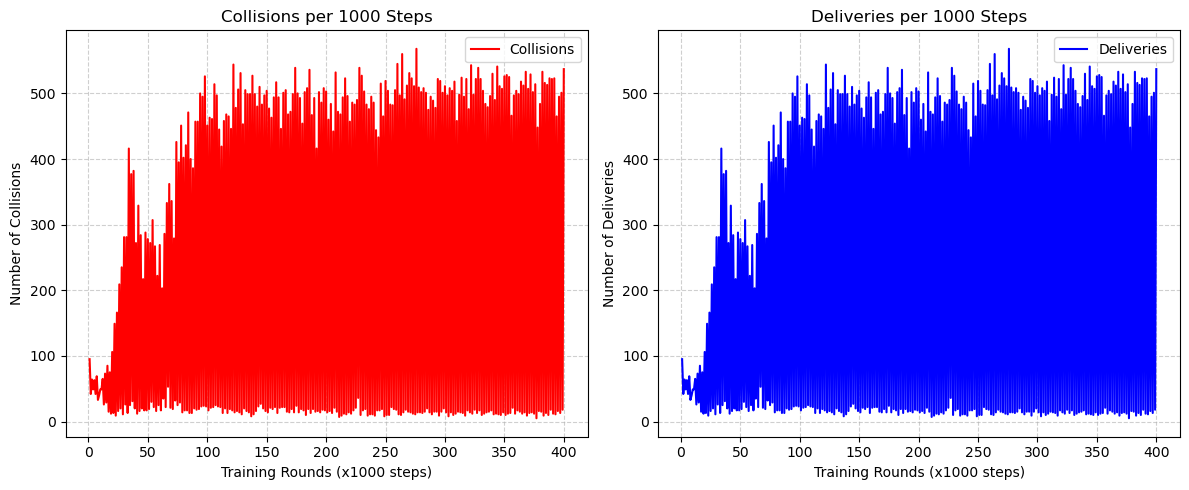

In [107]:
import matplotlib.pyplot as plt

def plot_training_results(collision_hist, delivery_hist):
    """Plot collision count and delivery count statistics"""
    plt.figure(figsize=(12, 5))
    
    # Plot collision count curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(collision_hist)+1), collision_hist, 'r-', label='Collisions')
    plt.title('Collisions per 1000 Steps')
    plt.xlabel('Training Rounds (x1000 steps)')
    plt.ylabel('Number of Collisions')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Plot delivery count curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(delivery_hist)+1), delivery_hist, 'b-', label='Deliveries')
    plt.title('Deliveries per 1000 Steps')
    plt.xlabel('Training Rounds (x1000 steps)')
    plt.ylabel('Number of Deliveries')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300)
    plt.show()

# In training code, call this function after training completes:
 
if __name__ == "__main__":
#     trained_agent, col_hist, deliv_hist = train()
      plot_training_results(col_hist, deliv_hist)

In [108]:
# =========================================================
# 0. 先确保环境常量和类已在内存
#    如果你把它们写在别的 *.py 文件，记得：
#    from fit5226_env   import MultiAgentGridEnv, NUM_AGENTS, GRID_SIZE
#    from fit5226_agent import DQNAgent
# =========================================================
import torch, os

ckpt_path = "checkpoints/dqn_weights.pt"
assert os.path.isfile(ckpt_path), "❌ 找不到权重文件，请先训练并保存！"

raw = torch.load(ckpt_path, map_location="cpu")

# -------- 自动兼容各种保存格式 --------
if isinstance(raw, dict):
    if "policy_state" in raw:            # ← 本示例的保存方式
        state_dict = raw["policy_state"]
    elif "state_dict" in raw:            # 例如 Lightning 保存格式
        state_dict = raw["state_dict"]
    elif "model" in raw:                 # 你以前手动保存 {'model': ...}
        state_dict = raw["model"]
    else:                                # 直接就是 OrderedDict
        state_dict = raw
else:
    state_dict = raw                     # torch.save(net.state_dict()) 的情况

# -------- 构建测试智能体并加载 --------
test_agent = DQNAgent(device="cpu")      # 用 GPU 就改 "cuda"
test_agent.policy_net.load_state_dict(state_dict)
test_agent.target_net.load_state_dict(test_agent.policy_net.state_dict())
test_agent.epsilon = 0.0                 # 评测阶段关闭 ε‑随机

print("✔ 模型加载完成，epsilon = 0")

✔ 模型加载完成，epsilon = 0


/var/folders/pd/bgkv2_gs33v_m67dpzn7lrb00000gn/T/ipykernel_66109/3084848775.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(ckpt_path, map_location="cp

In [109]:
# 0. 先确保环境常量和类已在内存
#    如果你把它们写在别的 *.py 文件，记得：
#    from fit5226_env   import MultiAgentGridEnv, NUM_AGENTS, GRID_SIZE
#    from fit5226_agent import DQNAgent
# =========================================================
import torch, os

ckpt_path = "checkpoints/dqn_weights.pt"
assert os.path.isfile(ckpt_path), "❌ 找不到权重文件，请先训练并保存！"

raw = torch.load(ckpt_path, map_location="cpu")

# -------- 自动兼容各种保存格式 --------
if isinstance(raw, dict):
    if "policy_state" in raw:            # ← 本示例的保存方式
        state_dict = raw["policy_state"]
    elif "state_dict" in raw:            # 例如 Lightning 保存格式
        state_dict = raw["state_dict"]
    elif "model" in raw:                 # 你以前手动保存 {'model': ...}
        state_dict = raw["model"]
    else:                                # 直接就是 OrderedDict
        state_dict = raw
else:
    state_dict = raw                     # torch.save(net.state_dict()) 的情况

# -------- 构建测试智能体并加载 --------
test_agent = DQNAgent(device="cpu")      # 用 GPU 就改 "cuda"
test_agent.policy_net.load_state_dict(state_dict)
test_agent.target_net.load_state_dict(test_agent.policy_net.state_dict())
test_agent.epsilon = 0.05                # 评测阶段关闭 ε‑随机

print("✔ 模型加载完成，epsilon = "+str(test_agent.epsilon))

✔ 模型加载完成，epsilon = 0.05


/var/folders/pd/bgkv2_gs33v_m67dpzn7lrb00000gn/T/ipykernel_66109/643182975.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(ckpt_path, map_location="cpu

测试情况

In [111]:
# =============================================================
# 0. 先确保 MultiAgentGridEnv、NUM_AGENTS、GRID_SIZE 已 import
#    from fit5226_env import MultiAgentGridEnv, NUM_AGENTS, GRID_SIZE
#    并且上面那段 “模型加载” cell 已经把 test_agent 创建完毕
# =============================================================

MAX_TEST_STEPS = 25   # 单回合步数上限

class TestEnv(MultiAgentGridEnv):
    """允许外部指定 A/B 与首发站位"""
    def reset_with_config(self, A, B, k_at_B):
        self.A, self.B = A, B
        self.positions = [B]*k_at_B + [A]*(self.num_agents - k_at_B)
        self.carry     = [0]*k_at_B + [1]*(self.num_agents - k_at_B)
        self.directions = [(0,0)]*self.num_agents
        self.heading    = [0]*self.num_agents
        self.total_collisions = 0
        self.clock_idx  = 0
        return {i: self._observe(i) for i in range(self.num_agents)}

def reached_success(env, route_state, started_at_B):
    """
    满足：
      ● 任意从 B 出发的 agent，route_state==2（BAB 完成）
      ● 全程无碰撞
    即判定成功
    """
    if env.total_collisions > 0:
        return False
    return any(st and rs==2 for st,rs in zip(started_at_B, route_state))

# ------------------- 穷 尽 测 试 -------------------
test_env = TestEnv()

total_cases   = 0
success_cases = 0

all_cells = [(x,y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]
combos    = [(A,B) for A in all_cells for B in all_cells if A!=B]

for A,B in combos:
    for k in (4,3,2,1):
        obs = test_env.reset_with_config(A, B, k_at_B=k)

        started_at_B = [True]*k + [False]*(NUM_AGENTS-k)
        route_state  = [0]*NUM_AGENTS        # 0/1/2

        for _ in range(MAX_TEST_STEPS):
            # 用 DQN 选动作（epsilon 已设 0）
            actions = {i: test_agent.choose_action(obs[i])
                       for i in range(NUM_AGENTS)}
            obs, _, _, info = test_env.step(actions)

            # 路径状态更新
            for i in range(NUM_AGENTS):
                if not started_at_B[i]:
                    continue
                if route_state[i]==0 and test_env.carry[i]==1:
                    route_state[i] = 1
                elif (route_state[i]==1 and
                      test_env.carry[i]==0 and
                      test_env.positions[i]==test_env.B):
                    route_state[i] = 2

            if reached_success(test_env, route_state, started_at_B):
                success_cases += 1
                break

        total_cases += 1

print(f"全部 {total_cases} 组情景 → 成功 {success_cases} 组，"
      f"成功率 = {success_cases/total_cases:.2%}")

全部 2400 组情景 → 成功 2062 组，成功率 = 85.92%


DQN 智能体代码实现了强化学习所需的关键组件：

经验回放 (Replay Buffer)：使用 deque(maxlen=10000) 存储最近的一定数量经验。每次调用learn都会将新的 (s, a, r, s') 对加入缓冲区。当累积的经验数超过 batch_size 后，即开始从缓冲区随机采样小批量进行训练​这样打乱了相关样本顺序，减少了时间相关性，提高了训练稳定性和数据效率。

ε-贪心策略：在 choose_action 方法中实现。Agent以一定概率 ε 随机选择动作（探索），其余情况下选择当前Q网络估计值最高的动作（利用）。初始 epsilon=1.0（完全探索），随着训练逐步按 epsilon_decay=0.995 衰减，每轮乘以0.995，逐渐降低到 epsilon_min=0.01，保留少量探索。这样保证了前期充分探索环境，后期更多利用学到的策略。

目标网络 (Target Network)：在 __init__ 中通过 prepare_torch() 建立了主Q网络和其副本目标网络。训练时通过 get_maxQ 查询目标网络对下一状态的最大Q值来计算稳定的 TD目标，从而避免主网络参数更新时目标值的剧烈变化​。我们每隔固定步数（如每1000次训练更新）调用 update_target() 将主网络参数拷贝给目标网络，同步两者。这样做能减缓训练过程中的震荡，使Q值逼近更稳定​

网络训练：利用teacher模块提供的函数封装，我们将采样的状态批、执行动作和对应TD目标组装后，调用 train_one_step 进行一次梯度更新。teacher模块内部定义了一个简单的三层全连接神经网络（输入层维度=状态空间维度15，两个隐藏层各24个单元，输出层4个单元对应4个动作Q值）。损失使用MSE，将预测的Q值向目标值靠拢。由于使用PyTorch，我们可以高效地在GPU上并行计算 batch 样本的梯度。

参数调整：gamma=0.95 适度考虑未来回报；经验缓冲区设较大容量避免过早丢弃经验；batch_size=32 则在每个训练步骤使用32条经验。学习步计数确保目标网络同步的频率合理（每1000步）。

通过上述实现，DQNAgent每一步都会将经历存储，并在有足够样本后不断采样训练。ε逐渐减小意味着智能体会从最初的探索驱动逐步变为策略驱动，配合经验回放和目标网络使训练更加稳定高效。

训练过程与统计



我们将 DQN 智能体应用于多智能体环境进行训练。在训练脚本中，创建4个智能体实例并让它们共享同一个DQN网络（即所有Agent对象引用同一个DQNAgent实例）。这样4个Agent在不同状态下收集的经验都存入共享的Replay Buffer，共同训练一个全局策略网络。这符合题目要求可以采用共享网络的方案，也能加速学习。